This workbook takes construction funding data from Power BI and exports summarized data

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cx_Oracle
cx_Oracle.init_oracle_client(lib_dir=r"C:\Oracle\instantclient_21_6")

In [2]:
#Import Funding data
Construction_details_base_df = pd.read_excel(r'FundingDetailsExport/Details_Export_Table.xlsx',sheet_name = 'Export')
Construction_Funding_df = Construction_details_base_df.copy()

C:\Users\AD21236\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
Construction_Funding_df.head()

,PROJECT_TYPE,SITE_PROJECT_TYPE,ST_SITE_PHASE,ST_PROJECT_ID,SITE_ST_PROJECT_ID,FW_PROJECT_ID,PHASE_PROJECT_STATUS,PHASE_STAR_ID_11,SITE_STAR_ID_11,PHASE_STAR_ID_12,...,SITE_RESPONSIBLE_PERSON_NAME,PHASE_SPLICING_SUPERVISOR_NAME,SITE_SPLICING_SUPERVISOR_NAME,POWER_COMPANY_NAME,POWER_SOURCE,POWER_SOURCE_LOCATION,PRIMARY_POWER_COMPANY_NAME,SECONDARY_POWER_COMPANY_NAME,TURNED_UP_MARKET_LAUNCH_A,OSP_CONSTRUCTION_COMPLETE_A
0,GPON Corporate Program,GPON Corporate Program,SITE,P-024496,P-024496,N.216454,Pre-Engineering,XGS Redesign Review Needed,XGS Redesign Review Needed,NaN,...,AMY 0922MAULDIN,NaN,NaN,Avista,Not Required,Not Required,Avista,NaN,NaT,NaT
1,GPON Corporate Program,GPON Corporate Program,SITE,P-024500,P-024500,N.216464,Pre-Engineering,XGS Redesign Review Needed,XGS Redesign Review Needed,NaN,...,AMY 0922MAULDIN,NaN,NaN,Avista,Not Required,Not Required,Avista,NaN,NaT,NaT
2,GPON Corporate Program,GPON Corporate Program,SITE,P-024502,P-024502,N.216467,Turn Up,XGS Redesign Review Needed,XGS Redesign Review Needed,NaN,...,AMY 0922MAULDIN,NaN,NaN,Avista,Not Required,Not Required,Avista,NaN,2022-09-09,2022-08-19
3,GPON Corporate Program,GPON Corporate Program,SITE,P-024566,P-024566,N.222956,Engineering,XGS Redesign Review Complete,XGS Redesign Review Complete,NaN,...,MIKE SHELDON,ANDREW SNIEDZE,ANDREW SNIEDZE,Xcel Energy,Not Required,Not Required,NaN,NaN,NaT,NaT
4,GPON Corporate Program,GPON Corporate Program,SITE,P-024580,P-024580,N.222970,Construction,XGS Redesign Review Complete,XGS Redesign Review Complete,NaN,...,MIKE SHELDON,ANDREW SNIEDZE,ANDREW SNIEDZE,Xcel Energy,Not Required,Not Required,NaN,NaN,2022-09-16,2022-08-25


In [4]:
# get funding data for date frame - need to update date filters if necessary
Construction_Funding_df = Construction_Funding_df.loc[Construction_Funding_df['PHASE_ECD_LOGIC'] >= '1-JAN-2022',["PRIMARY_WIRE_CENTER_ID", "PHASE_ECD_LOGIC", "PHASE_NUM_OF_LUS"]].dropna(subset=["PRIMARY_WIRE_CENTER_ID"])


In [5]:
Construction_Funding_df.head()

,PRIMARY_WIRE_CENTER_ID,PHASE_ECD_LOGIC,PHASE_NUM_OF_LUS
0,SPKNWA01,2022-11-18,322.0
1,SPKNWA01,2022-11-18,167.0
2,SPKNWA01,2022-09-07,134.0
3,MPLSMNBE,2022-12-05,398.0
4,MPLSMNBE,2022-09-09,413.0


In [6]:
Construction_Funding_df['PHASE_ECD_LOGIC'] = Construction_Funding_df['PHASE_ECD_LOGIC'].dt.to_period('M')

In [7]:
Construction_Funding_df['PHASE_ECD_LOGIC'] = Construction_Funding_df['PHASE_ECD_LOGIC'].astype(str)

In [8]:
Construction_pivot = Construction_Funding_df.groupby(by = ["PRIMARY_WIRE_CENTER_ID","PHASE_ECD_LOGIC"], as_index = False).sum()
Construction_pivot = Construction_pivot.pivot(index='PRIMARY_WIRE_CENTER_ID', columns='PHASE_ECD_LOGIC')['PHASE_NUM_OF_LUS'].reset_index()

In [9]:
Construction_pivot = Construction_pivot.fillna(0)

In [10]:
# check this before manual date update below
Construction_pivot.head()

PHASE_ECD_LOGIC,PRIMARY_WIRE_CENTER_ID,2022-09,2022-10,2022-11,2022-12
0,ALSPFLXA,0.0,0.0,0.0,550.0
1,APPKFLXA,0.0,0.0,0.0,97.0
2,AUBNWA01,0.0,0.0,971.0,381.0
3,BLANMNBL,0.0,0.0,0.0,344.0
4,CLSPCOMA,0.0,1167.0,0.0,0.0


In [11]:
# manually update date if necessary
Construction_pivot['TOTAL_2022'] = Construction_pivot['2022-09'] + Construction_pivot['2022-10'] + Construction_pivot['2022-11'] + Construction_pivot['2022-12']

In [12]:
Construction_pivot.head() # contains construction funded info

PHASE_ECD_LOGIC,PRIMARY_WIRE_CENTER_ID,2022-09,2022-10,2022-11,2022-12,TOTAL_2022
0,ALSPFLXA,0.0,0.0,0.0,550.0,550.0
1,APPKFLXA,0.0,0.0,0.0,97.0,97.0
2,AUBNWA01,0.0,0.0,971.0,381.0,1352.0
3,BLANMNBL,0.0,0.0,0.0,344.0,344.0
4,CLSPCOMA,0.0,1167.0,0.0,0.0,1167.0


In [13]:
# Import opportunity scores
OppScore_df = pd.read_excel(r'Inputs/CLLI_ZIP_XREF_WEIGHTED_SCORE.xlsx',sheet_name = 'Final')

# Import core status multigig readiness
MGR_df = pd.read_excel(r'Inputs/081622_OpportunityScore_MultiGig_Readiness.xlsx',sheet_name = 'Datasheet')


In [14]:
OppScore_df = OppScore_df.rename(columns = {'CLLI': 'PRIMARY_WIRE_CENTER_ID'})
OppScore_df = OppScore_df[['PRIMARY_WIRE_CENTER_ID','Weighted Opportunity Score']]

In [15]:
Construction_pivot = Construction_pivot.merge(OppScore_df, how = 'left', on = 'PRIMARY_WIRE_CENTER_ID')

In [16]:
MGR_df = MGR_df[['PRIMARY_WIRE_CENTER_ID','STATE','Core Status','Cost for Multi-Gig']]

In [17]:
Construction_final = Construction_pivot.merge(MGR_df, how = 'left', on = 'PRIMARY_WIRE_CENTER_ID')

In [18]:
Construction_final = Construction_final.rename(columns = {'Weighted Opportunity Score': 'OPPORTUNITY_SCORE',
                                     'Core Status': 'CORE_STATUS',
                                     'Cost for Multi-Gig': 'COST_FOR_MULTIGIG'})
Construction_final['CORE_STATUS'] = Construction_final['CORE_STATUS'].fillna('Not in MultiGig Readiness Worksheet')

In [19]:
Construction_final.head()

,PRIMARY_WIRE_CENTER_ID,2022-09,2022-10,2022-11,2022-12,TOTAL_2022,OPPORTUNITY_SCORE,STATE,CORE_STATUS,COST_FOR_MULTIGIG
0,ALSPFLXA,0.0,0.0,0.0,550.0,550.0,11.0,FL,940M Only,0.0
1,APPKFLXA,0.0,0.0,0.0,97.0,97.0,14.0,FL,940M Only,300000.0
2,AUBNWA01,0.0,0.0,971.0,381.0,1352.0,6.0,WA,XGS-PON - 120,25000.0
3,BLANMNBL,0.0,0.0,0.0,344.0,344.0,10.0,MN,Planning - 120,25000.0
4,CLSPCOMA,0.0,1167.0,0.0,0.0,1167.0,13.0,CO,XGS-PON - 180,75000.0


In [20]:
# separate into MG and non-MG data, filter out data with no opportunity score
mg_mask = (Construction_final['CORE_STATUS'] == 'MultiGIG') & (Construction_final['OPPORTUNITY_SCORE'] > 0)
non_mg_mask = (Construction_final['CORE_STATUS'] != 'MultiGIG') & (Construction_final['OPPORTUNITY_SCORE'] > 0)

MGR = Construction_final[mg_mask]
NMGR = Construction_final[non_mg_mask]

In [21]:
# Create Opportunity Score Range for MG

conditions = [
    (MGR['OPPORTUNITY_SCORE'] >= 12),
    (MGR['OPPORTUNITY_SCORE'] >= 9) & (MGR['OPPORTUNITY_SCORE'] < 12),
    (MGR['OPPORTUNITY_SCORE'] < 9)
    ]

values = ['HIGH', 'MEDIUM', 'LOW']

MGR['OPPORTUNITY_SCORE_TIER'] = np.select(conditions, values)

C:\Windows\Temp\ipykernel_16068\1141439409.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MGR['OPPORTUNITY_SCORE_TIER'] = np.select(conditions, values)


In [22]:
# Create Opportunity Score Range for non-MG

conditions = [
    (NMGR['OPPORTUNITY_SCORE'] >= 12),
    (NMGR['OPPORTUNITY_SCORE'] >= 9) & (NMGR['OPPORTUNITY_SCORE'] < 12),
    (NMGR['OPPORTUNITY_SCORE'] < 9)
    ]

values = ['HIGH', 'MEDIUM', 'LOW']

NMGR['OPPORTUNITY_SCORE_TIER'] = np.select(conditions, values)

C:\Windows\Temp\ipykernel_16068\2461150363.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NMGR['OPPORTUNITY_SCORE_TIER'] = np.select(conditions, values)


Non-MultiGig tables outputs start here

In [23]:
# Data prep for non-MG summary table
opp_mask = NMGR["OPPORTUNITY_SCORE_TIER"] == "HIGH"

# Pivot data for state summary LU - update "Total" column to "2022 Total" or "2023 Total" if need year-specific

State_GRP_df = NMGR.groupby('STATE', as_index = False)['TOTAL_2022'].sum()
State_GRP_df = State_GRP_df.sort_values('TOTAL_2022', ascending = False)
State_GRP_df['TOTAL_2022'] = State_GRP_df['TOTAL_2022'].astype(int)
State_GRP_df

# Clean data to add count of high/medium/low opportunity wire centers

WC_df_GRP = NMGR[opp_mask].groupby('STATE', as_index = False)['PRIMARY_WIRE_CENTER_ID'].count()
WC_df_GRP.rename(columns={"PRIMARY_WIRE_CENTER_ID": "HIGH_OPP_WC_CNT"}, inplace = True)
WC_df_GRP.sort_values('HIGH_OPP_WC_CNT', ascending = False, inplace = True)
WC_df_GRP

WC_LU_df = NMGR[opp_mask].groupby('STATE', as_index = False)['TOTAL_2022'].sum()
WC_LU_df.rename(columns={"TOTAL_2022": "HIGH_OPP_LU_CNT"}, inplace = True)
WC_LU_df.sort_values('HIGH_OPP_LU_CNT', ascending = False, inplace = True)
WC_LU_df

State_Sum_DF = State_GRP_df.merge(WC_df_GRP, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['HIGH_OPP_WC_CNT'] = State_Sum_DF['HIGH_OPP_WC_CNT'].astype(int)
State_Sum_DF.sort_values('HIGH_OPP_WC_CNT', ascending = False, inplace = True)

# join in WC LU by opportunity range
State_Sum_DF = State_Sum_DF.merge(WC_LU_df, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['HIGH_OPP_LU_CNT'] = State_Sum_DF['HIGH_OPP_LU_CNT'].astype(int)
State_Sum_DF


# Sort value by living units

State_Sum_DF.sort_values(by = ['TOTAL_2022'], ascending = False, inplace = True)
nonMG_high_State_Sum_DF = State_Sum_DF.copy() # making a copy for export

In [24]:
# Data prep for non-MG summary table
opp_mask = NMGR["OPPORTUNITY_SCORE_TIER"] == "MEDIUM"

# Pivot data for state summary LU - update "Total" column to "2022 Total" or "2023 Total" if need year-specific

State_GRP_df = NMGR.groupby('STATE', as_index = False)['TOTAL_2022'].sum()
State_GRP_df = State_GRP_df.sort_values('TOTAL_2022', ascending = False)
State_GRP_df['TOTAL_2022'] = State_GRP_df['TOTAL_2022'].astype(int)
State_GRP_df

# Clean data to add count of high/medium/low opportunity wire centers

WC_df_GRP = NMGR[opp_mask].groupby('STATE', as_index = False)['PRIMARY_WIRE_CENTER_ID'].count()
WC_df_GRP.rename(columns={"PRIMARY_WIRE_CENTER_ID": "MED_OPP_WC_CNT"}, inplace = True)
WC_df_GRP.sort_values('MED_OPP_WC_CNT', ascending = False, inplace = True)
WC_df_GRP

WC_LU_df = NMGR[opp_mask].groupby('STATE', as_index = False)['TOTAL_2022'].sum()
WC_LU_df.rename(columns={"TOTAL_2022": "MED_OPP_LU_CNT"}, inplace = True)
WC_LU_df.sort_values('MED_OPP_LU_CNT', ascending = False, inplace = True)
WC_LU_df

State_Sum_DF = State_GRP_df.merge(WC_df_GRP, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['MED_OPP_WC_CNT'] = State_Sum_DF['MED_OPP_WC_CNT'].astype(int)
State_Sum_DF.sort_values('MED_OPP_WC_CNT', ascending = False, inplace = True)

# join in WC LU by opportunity range
State_Sum_DF = State_Sum_DF.merge(WC_LU_df, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['MED_OPP_LU_CNT'] = State_Sum_DF['MED_OPP_LU_CNT'].astype(int)
State_Sum_DF


# Sort value by living units

State_Sum_DF.sort_values(by = ['TOTAL_2022'], ascending = False, inplace = True)
nonMG_medium_State_Sum_DF = State_Sum_DF.copy() # for export

In [25]:
# Data prep for non-MG summary table
opp_mask = NMGR["OPPORTUNITY_SCORE_TIER"] == "LOW"

# Pivot data for state summary LU - update "Total" column to "2022 Total" or "2023 Total" if need year-specific

State_GRP_df = NMGR.groupby('STATE', as_index = False)['TOTAL_2022'].sum()
State_GRP_df = State_GRP_df.sort_values('TOTAL_2022', ascending = False)
State_GRP_df['TOTAL_2022'] = State_GRP_df['TOTAL_2022'].astype(int)
State_GRP_df

# Clean data to add count of high/medium/low opportunity wire centers

WC_df_GRP = NMGR[opp_mask].groupby('STATE', as_index = False)['PRIMARY_WIRE_CENTER_ID'].count()
WC_df_GRP.rename(columns={"PRIMARY_WIRE_CENTER_ID": "LOW_OPP_WC_CNT"}, inplace = True)
WC_df_GRP.sort_values('LOW_OPP_WC_CNT', ascending = False, inplace = True)
WC_df_GRP

WC_LU_df = NMGR[opp_mask].groupby('STATE', as_index = False)['TOTAL_2022'].sum()
WC_LU_df.rename(columns={"TOTAL_2022": "LOW_OPP_LU_CNT"}, inplace = True)
WC_LU_df.sort_values('LOW_OPP_LU_CNT', ascending = False, inplace = True)
WC_LU_df

State_Sum_DF = State_GRP_df.merge(WC_df_GRP, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['LOW_OPP_WC_CNT'] = State_Sum_DF['LOW_OPP_WC_CNT'].astype(int)
State_Sum_DF.sort_values('LOW_OPP_WC_CNT', ascending = False, inplace = True)

# join in WC LU by opportunity range
State_Sum_DF = State_Sum_DF.merge(WC_LU_df, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['LOW_OPP_LU_CNT'] = State_Sum_DF['LOW_OPP_LU_CNT'].astype(int)
State_Sum_DF


# Sort value by living units

State_Sum_DF.sort_values(by = ['TOTAL_2022'], ascending = False, inplace = True)
nonMG_low_State_Sum_DF = State_Sum_DF.copy() # for export

In [26]:
# data prep for cost-opportunity bar chart - nonMG

NMGR_costs_df = NMGR.groupby(by=["STATE", "OPPORTUNITY_SCORE_TIER"], as_index = False)['COST_FOR_MULTIGIG'].sum()
NMGR_tier_df = NMGR.groupby(["STATE", "OPPORTUNITY_SCORE_TIER"], as_index = False).size()
NMGR_LU_df = NMGR.groupby(by=["STATE", "OPPORTUNITY_SCORE_TIER"], as_index = False)["TOTAL_2022"].sum()

NMGR_Agg0_df = NMGR_tier_df.merge(NMGR_costs_df, how = 'left', on = ['STATE', 'OPPORTUNITY_SCORE_TIER'])
NMGR_Agg_df = NMGR_Agg0_df.merge(NMGR_LU_df, how = 'left', on = ['STATE', 'OPPORTUNITY_SCORE_TIER'])

# sort table

NMGR_Agg_df['OPPORTUNITY_SCORE_TIER'] = pd.Categorical(NMGR_Agg_df['OPPORTUNITY_SCORE_TIER'], ["HIGH", "MEDIUM", "LOW"])
NMGR_Agg_df.sort_values("OPPORTUNITY_SCORE_TIER", inplace = True)
NMGR_Agg_df

NMGR_Agg_df = NMGR_Agg_df.rename(columns = {'size': 'NUM_OF_WIRE_CENTERS',
                              'TOTAL_2022': 'NUM_OF_LIVING_UNITS'})

nonMG_cost_agg = NMGR_Agg_df.copy() # for export

Multigig output starts here

In [27]:
# Data prep for Multi-gig summary table
opp_mask = MGR["OPPORTUNITY_SCORE_TIER"] == "HIGH"

# Pivot data for state summary LU - update "Total" column to "2022 Total" or "2023 Total" if need year-specific

State_GRP_df = MGR.groupby('STATE', as_index = False)['TOTAL_2022'].sum()
State_GRP_df = State_GRP_df.sort_values('TOTAL_2022', ascending = False)
State_GRP_df['TOTAL_2022'] = State_GRP_df['TOTAL_2022'].astype(int)
State_GRP_df

# Clean data to add count of high/medium/low opportunity wire centers

WC_df_GRP = MGR[opp_mask].groupby('STATE', as_index = False)['PRIMARY_WIRE_CENTER_ID'].count()
WC_df_GRP.rename(columns={"PRIMARY_WIRE_CENTER_ID": "HIGH_OPP_WC_CNT"}, inplace = True)
WC_df_GRP.sort_values('HIGH_OPP_WC_CNT', ascending = False, inplace = True)
WC_df_GRP

WC_LU_df = MGR[opp_mask].groupby('STATE', as_index = False)['TOTAL_2022'].sum()
WC_LU_df.rename(columns={"TOTAL_2022": "HIGH_OPP_LU_CNT"}, inplace = True)
WC_LU_df.sort_values('HIGH_OPP_LU_CNT', ascending = False, inplace = True)
WC_LU_df

State_Sum_DF = State_GRP_df.merge(WC_df_GRP, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['HIGH_OPP_WC_CNT'] = State_Sum_DF['HIGH_OPP_WC_CNT'].astype(int)
State_Sum_DF.sort_values('HIGH_OPP_WC_CNT', ascending = False, inplace = True)

# join in WC LU by opportunity range
State_Sum_DF = State_Sum_DF.merge(WC_LU_df, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['HIGH_OPP_LU_CNT'] = State_Sum_DF['HIGH_OPP_LU_CNT'].astype(int)
State_Sum_DF


# Sort value by living units

State_Sum_DF.sort_values(by = ['TOTAL_2022'], ascending = False, inplace = True)
MG_high_State_Sum_DF = State_Sum_DF.copy() # for export

In [28]:
# Data prep for Multi-gig summary table
opp_mask = MGR["OPPORTUNITY_SCORE_TIER"] == "MEDIUM"

# Pivot data for state summary LU - update "Total" column to "2022 Total" or "2023 Total" if need year-specific

State_GRP_df = MGR.groupby('STATE', as_index = False)['TOTAL_2022'].sum()
State_GRP_df = State_GRP_df.sort_values('TOTAL_2022', ascending = False)
State_GRP_df['TOTAL_2022'] = State_GRP_df['TOTAL_2022'].astype(int)
State_GRP_df

# Clean data to add count of high/medium/low opportunity wire centers

WC_df_GRP = MGR[opp_mask].groupby('STATE', as_index = False)['PRIMARY_WIRE_CENTER_ID'].count()
WC_df_GRP.rename(columns={"PRIMARY_WIRE_CENTER_ID": "MED_OPP_WC_CNT"}, inplace = True)
WC_df_GRP.sort_values('MED_OPP_WC_CNT', ascending = False, inplace = True)
WC_df_GRP

WC_LU_df = MGR[opp_mask].groupby('STATE', as_index = False)['TOTAL_2022'].sum()
WC_LU_df.rename(columns={"TOTAL_2022": "MED_OPP_LU_CNT"}, inplace = True)
WC_LU_df.sort_values('MED_OPP_LU_CNT', ascending = False, inplace = True)
WC_LU_df

State_Sum_DF = State_GRP_df.merge(WC_df_GRP, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['MED_OPP_WC_CNT'] = State_Sum_DF['MED_OPP_WC_CNT'].astype(int)
State_Sum_DF.sort_values('MED_OPP_WC_CNT', ascending = False, inplace = True)

# join in WC LU by opportunity range
State_Sum_DF = State_Sum_DF.merge(WC_LU_df, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['MED_OPP_LU_CNT'] = State_Sum_DF['MED_OPP_LU_CNT'].astype(int)
State_Sum_DF


# Sort value by living units

State_Sum_DF.sort_values(by = ['TOTAL_2022'], ascending = False, inplace = True)
MG_medium_State_Sum_DF = State_Sum_DF.copy() # for export

In [29]:
# Data prep for Multi-gig summary table
opp_mask = MGR["OPPORTUNITY_SCORE_TIER"] == "LOW"

# Pivot data for state summary LU - update "Total" column to "2022 Total" or "2023 Total" if need year-specific

State_GRP_df = MGR.groupby('STATE', as_index = False)['TOTAL_2022'].sum()
State_GRP_df = State_GRP_df.sort_values('TOTAL_2022', ascending = False)
State_GRP_df['TOTAL_2022'] = State_GRP_df['TOTAL_2022'].astype(int)
State_GRP_df

# Clean data to add count of high/medium/low opportunity wire centers

WC_df_GRP = MGR[opp_mask].groupby('STATE', as_index = False)['PRIMARY_WIRE_CENTER_ID'].count()
WC_df_GRP.rename(columns={"PRIMARY_WIRE_CENTER_ID": "LOW_OPP_WC_CNT"}, inplace = True)
WC_df_GRP.sort_values('LOW_OPP_WC_CNT', ascending = False, inplace = True)
WC_df_GRP

WC_LU_df = MGR[opp_mask].groupby('STATE', as_index = False)['TOTAL_2022'].sum()
WC_LU_df.rename(columns={"TOTAL_2022": "LOW_OPP_LU_CNT"}, inplace = True)
WC_LU_df.sort_values('LOW_OPP_LU_CNT', ascending = False, inplace = True)
WC_LU_df

State_Sum_DF = State_GRP_df.merge(WC_df_GRP, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['LOW_OPP_WC_CNT'] = State_Sum_DF['LOW_OPP_WC_CNT'].astype(int)
State_Sum_DF.sort_values('LOW_OPP_WC_CNT', ascending = False, inplace = True)

# join in WC LU by opportunity range
State_Sum_DF = State_Sum_DF.merge(WC_LU_df, how = 'left', on = 'STATE').fillna(0)
State_Sum_DF['LOW_OPP_LU_CNT'] = State_Sum_DF['LOW_OPP_LU_CNT'].astype(int)
State_Sum_DF


# Sort value by living units

State_Sum_DF.sort_values(by = ['TOTAL_2022'], ascending = False, inplace = True)
MG_low_State_Sum_DF = State_Sum_DF.copy() # for export

In [30]:
# export

import time

TodaysDate = time.strftime("%m%d%y")
excelfilename = "Output/" + TodaysDate +"_ConstructionFunded_Summary_Data.xlsx"

with pd.ExcelWriter(excelfilename) as writer:  
    nonMG_high_State_Sum_DF.to_excel(writer, sheet_name='NonMG_HighOpportunity', index = False)
    nonMG_medium_State_Sum_DF.to_excel(writer, sheet_name='NonMG_MedOpportunity', index = False)
    nonMG_low_State_Sum_DF.to_excel(writer, sheet_name='NonMG_LowOpportunity', index = False)
    nonMG_cost_agg.to_excel(writer, sheet_name='NonMG_Cost_Summary', index = False)
    MG_high_State_Sum_DF.to_excel(writer, sheet_name='MG_HighOpportunity', index = False)
    MG_medium_State_Sum_DF.to_excel(writer, sheet_name='MG_MedOpportunity', index = False)
    MG_low_State_Sum_DF.to_excel(writer, sheet_name='MG_LowOpportunity', index = False)
    Construction_final.to_excel(writer, sheet_name='Details', index = False)
    Construction_details_base_df.to_excel(writer, sheet_name='FundingOriginalExport', index = False)

Graph for MultiGig - Wire Center Details

In [31]:
MGR.head()

,PRIMARY_WIRE_CENTER_ID,2022-09,2022-10,2022-11,2022-12,TOTAL_2022,OPPORTUNITY_SCORE,STATE,CORE_STATUS,COST_FOR_MULTIGIG,OPPORTUNITY_SCORE_TIER
10,CSRKCONM,0.0,87.0,0.0,0.0,87.0,14.0,CO,MultiGIG,0.0,HIGH
11,CTWDUTMA,0.0,0.0,0.0,258.0,258.0,11.0,UT,MultiGIG,0.0,MEDIUM
13,DNVRCOCP,0.0,44.0,124.0,0.0,168.0,15.0,CO,MultiGIG,0.0,HIGH
15,DRPRUTMA,0.0,0.0,510.0,950.0,1460.0,10.0,UT,MultiGIG,0.0,MEDIUM
16,FDWYWA01,0.0,0.0,487.0,0.0,487.0,9.0,WA,MultiGIG,0.0,MEDIUM


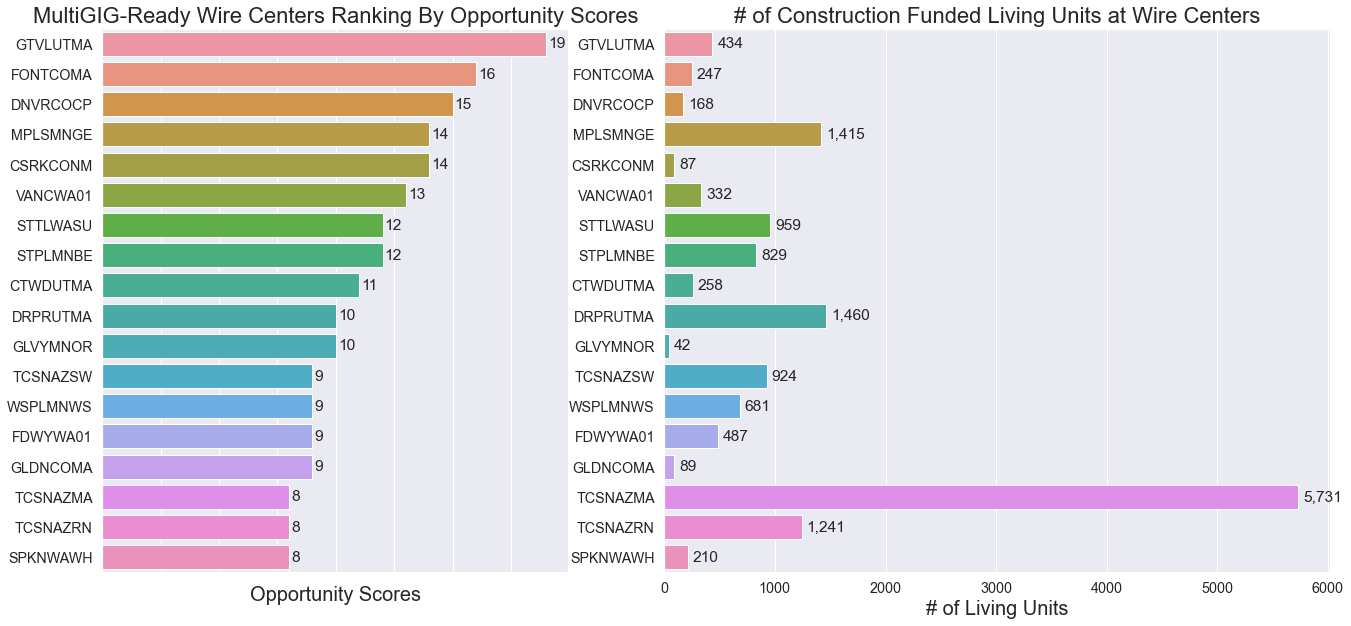

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# set graph space

fig2, (ax2, ax3) = plt.subplots(1,
                                2, 
                                figsize = (22, 10), 
                                gridspec_kw = {'width_ratios': [1.4, 2]})

# set opportunity score tier
opp_mask = (MGR["OPPORTUNITY_SCORE_TIER"] == "HIGH")|(MGR["OPPORTUNITY_SCORE_TIER"] == "MEDIUM")|(MGR["OPPORTUNITY_SCORE_TIER"] == "LOW")

# create graph
sns.set(font_scale = 1.3)
sns.barplot(x = "OPPORTUNITY_SCORE", 
            y = "PRIMARY_WIRE_CENTER_ID", 
            data = MGR[opp_mask].sort_values(by = ['OPPORTUNITY_SCORE', 'TOTAL_2022', 'PRIMARY_WIRE_CENTER_ID'], ascending = False),
            orient = 'h',
            ax = ax2).set(xticklabels = [])
sns.barplot(x = "TOTAL_2022", 
            y = "PRIMARY_WIRE_CENTER_ID", 
            #data=MultiGIG_df[:20].sort_values(by = ['Opportunity Score', 'WIRE_CENTER_ID'], ascending = False),
            data = MGR[opp_mask].sort_values(by = ['OPPORTUNITY_SCORE', 'TOTAL_2022', 'PRIMARY_WIRE_CENTER_ID'], ascending = False),
            orient = 'h',
            ax = ax3)

plt.subplots_adjust(wspace=.17, hspace=0)

# set axis properties ax2

ax2.set_title('MultiGIG-Ready Wire Centers Ranking By Opportunity Scores', fontsize = 22)
ax2.set(xlabel='Opportunity Scores', ylabel='')
ax2.xaxis.label.set_size(20)

# label value on bars
for i in ax2.containers:
    ax2.bar_label(i,
                 padding=2)

# set axis properties ax3

ax3.set_title('# of Construction Funded Living Units at Wire Centers', fontsize = 22)
ax3.set(xlabel='# of Living Units', ylabel='')
ax3.xaxis.label.set_size(20)

for i in ax3.containers:
    ax3.bar_label(i, 
                  labels=[f'{x:,.0f}' for x in i.datavalues], 
                  padding=5)
    
plt.show()    

# plt.savefig('Output/Graphs/MultiGIG-Ready_WC_Ranked_By_OppScores_LUs.png')
# plt.savefig('Output/Graphs/test.png')

Graph for non-multigig - cost-focused - WIP

In [33]:
# Get only relevant columns

nonMG_cost_graph = nonMG_cost_agg[['STATE','OPPORTUNITY_SCORE_TIER','NUM_OF_LIVING_UNITS','COST_FOR_MULTIGIG']]
nonMG_cost_graph = nonMG_cost_graph.pivot(index='STATE', columns='OPPORTUNITY_SCORE_TIER', values=['NUM_OF_LIVING_UNITS', 'COST_FOR_MULTIGIG']).reset_index()

In [115]:
nonMG_cost_graph.columns

MultiIndex([(              'STATE',       ''),
            ('NUM_OF_LIVING_UNITS',   'HIGH'),
            ('NUM_OF_LIVING_UNITS', 'MEDIUM'),
            ('NUM_OF_LIVING_UNITS',    'LOW'),
            (  'COST_FOR_MULTIGIG',   'HIGH'),
            (  'COST_FOR_MULTIGIG', 'MEDIUM'),
            (  'COST_FOR_MULTIGIG',    'LOW')],
           names=[None, 'OPPORTUNITY_SCORE_TIER'])

In [116]:
nonMG_cost_graph = nonMG_cost_graph.fillna(0)

In [117]:
# flatten index

nonMG_cost_graph.columns = nonMG_cost_graph.columns.get_level_values(0) + '_' +  nonMG_cost_graph.columns.get_level_values(1)


In [245]:
# ready for plot
nonMG_cost_graph['bottom_high'] = nonMG_cost_graph['COST_FOR_MULTIGIG_HIGH']+nonMG_cost_graph['COST_FOR_MULTIGIG_MEDIUM']+nonMG_cost_graph['COST_FOR_MULTIGIG_LOW']

In [246]:
nonMG_cost_graph

,STATE_,NUM_OF_LIVING_UNITS_HIGH,NUM_OF_LIVING_UNITS_MEDIUM,NUM_OF_LIVING_UNITS_LOW,COST_FOR_MULTIGIG_HIGH,COST_FOR_MULTIGIG_MEDIUM,COST_FOR_MULTIGIG_LOW,bottom_high
0,AZ,0.0,0.0,668.0,0.0,0.0,75000.0,75000.0
1,CO,8524.0,9103.0,0.0,195000.0,175000.0,0.0,370000.0
2,FL,2119.0,21240.0,3982.0,300000.0,450000.0,325000.0,1075000.0
3,IA,248.0,0.0,0.0,300000.0,0.0,0.0,300000.0
4,MN,2409.0,4638.0,0.0,50000.0,50000.0,0.0,100000.0
5,NV,135.0,0.0,0.0,35000.0,0.0,0.0,35000.0
6,OR,0.0,0.0,0.0,270000.0,0.0,0.0,270000.0
7,UT,5457.0,1066.0,0.0,25000.0,100000.0,0.0,125000.0
8,WA,0.0,2737.0,2078.0,0.0,280000.0,165000.0,445000.0


In [285]:
# nonMG_cost_graph[['NUM_OF_LIVING_UNITS_HIGH','NUM_OF_LIVING_UNITS_MEDIUM','NUM_OF_LIVING_UNITS_LOW']]
print(nonMG_cost_graph['NUM_OF_LIVING_UNITS_HIGH'].values)

[   0. 8524. 2119.  248. 2409.  135.    0. 5457.    0.]


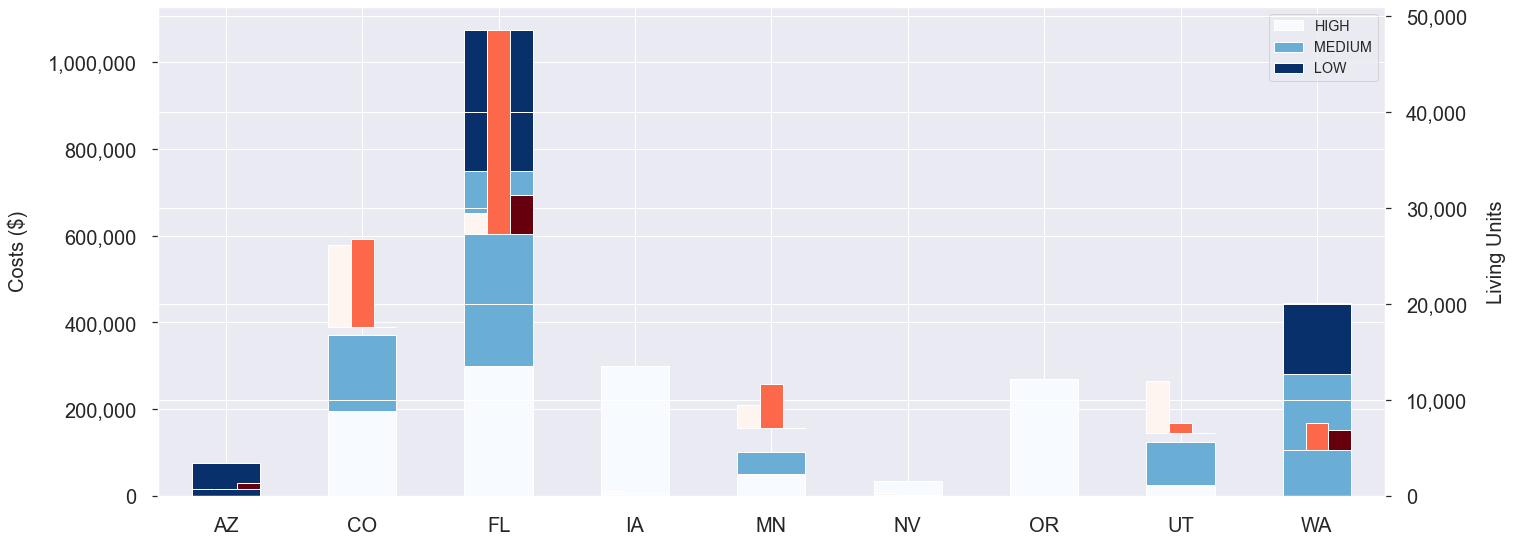

In [288]:
fig2, ax3 = plt.subplots(figsize = (22, 9))

nonMG_cost_graph.plot(x = 'STATE_', 
                      y = ['COST_FOR_MULTIGIG_HIGH','COST_FOR_MULTIGIG_MEDIUM','COST_FOR_MULTIGIG_LOW'], 
                      kind='bar', 
                      stacked = True, 
                      ax = ax3, 
                      colormap = 'Blues',
                      label = ['HIGH','MEDIUM','LOW'])
ax4 = ax3.twinx() # share y-axis

# float this

one = nonMG_cost_graph['NUM_OF_LIVING_UNITS_HIGH'].values
two = nonMG_cost_graph['NUM_OF_LIVING_UNITS_MEDIUM'].values
three = nonMG_cost_graph['NUM_OF_LIVING_UNITS_LOW'].values

L=[i+j+k for i,j,k in zip(one,two,three)]

nonMG_cost_graph.plot(x = 'STATE_',
                      y = ['NUM_OF_LIVING_UNITS_HIGH','NUM_OF_LIVING_UNITS_MEDIUM','NUM_OF_LIVING_UNITS_LOW'], 
                      kind='bar', 
                      stacked = False, 
                      ax = ax4,
                      colormap = 'Reds',
                      bottom = L)

# ax4.set_ylim([0, 80000])
# ax3.set_ylim([0, 700000])

ax4.get_legend().remove()

ax3.set_xlabel('')
ax3.set_ylabel('Costs ($)', labelpad=20)
ax3.yaxis.label.set_size(20)
ax4.set_ylabel('Living Units', labelpad=20)
ax4.yaxis.label.set_size(20)

ax3.tick_params(axis='x', labelsize=20, pad=15, labelrotation = 0)
ax3.tick_params(axis='y', labelsize=20, pad=15)
ax4.tick_params(axis='y', labelsize=20, pad=15)

import matplotlib as mpl

ax3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))